## Chapter 4 Code - Python 3 version

### glmnet2RocksVMines.py

0 1 2.0
0 2 1.0
1 1 2.0
1 2 1.0
2 1 2.0
2 2 1.0
3 1 3.0
3 2 1.0
4 1 3.0
4 2 1.0
5 1 4.0
5 2 1.0
6 1 4.0
6 2 1.0
7 1 4.0
7 2 1.0
8 1 4.0
8 2 1.0
9 1 4.0
9 2 1.0
10 1 3.0
10 2 1.0
11 1 3.0
11 2 1.0
12 1 4.0
12 2 1.0
13 1 4.0
13 2 1.0
14 1 4.0
14 2 1.0
15 1 3.0
15 2 1.0
16 1 3.0
16 2 1.0
17 1 4.0
17 2 1.0
18 1 4.0
18 2 1.0
19 1 4.0
19 2 1.0
20 1 3.0
20 2 1.0
21 1 4.0
21 2 1.0
22 1 3.0
22 2 1.0
23 1 4.0
23 2 1.0
24 1 4.0
24 2 1.0
25 1 4.0
25 2 1.0
26 1 4.0
26 2 1.0
27 1 4.0
27 2 1.0
28 1 4.0
28 2 1.0
29 1 5.0
29 2 2.0
29 3 1.0
30 1 4.0
30 2 2.0
31 1 4.0
31 2 2.0
32 1 4.0
32 2 2.0
33 1 4.0
33 2 2.0
33 3 2.0
34 1 4.0
34 2 3.0
34 3 2.0
35 1 4.0
35 2 3.0
35 3 2.0
36 1 4.0
36 2 3.0
36 3 2.0
37 1 6.0
37 2 2.0
37 3 2.0
38 1 6.0
38 2 2.0
38 3 2.0
39 1 5.0
39 2 2.0
39 3 2.0
40 1 5.0
40 2 2.0
40 3 2.0
41 1 5.0
41 2 2.0
41 3 2.0
42 1 5.0
42 2 2.0
42 3 2.0
42 4 1.0
43 1 5.0
43 2 2.0
43 3 2.0
43 4 1.0
44 1 5.0
44 2 3.0
44 3 2.0
44 4 1.0
45 1 5.0
45 2 2.0
45 3 2.0
45 4 1.0
46 1 4.0
46 2 2.0
46 3 2.0
46 

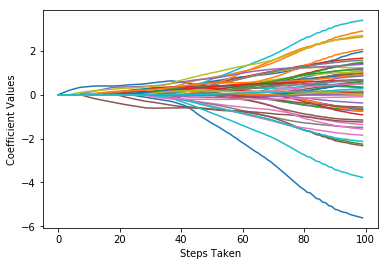

In [1]:
__author__ = 'mike_bowles'
import urllib.request, urllib.error, urllib.parse
import sys
from math import sqrt, fabs, exp
import matplotlib.pyplot as plot

def S(z,gamma):
    if gamma >= fabs(z):
        return 0.0
    if z > 0.0:
        return z - gamma
    else:
        return z + gamma

def Pr(b0,b,x):
    n = len(x)
    sum = b0
    for i in range(n):
        sum += b[i]*x[i]
        if sum < -100: sum = -100
    return 1.0/(1.0 + exp(-sum))


#read data from uci data repository
target_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/undocumented/connectionist-bench/sonar/sonar.all-data"
data = urllib.request.urlopen(target_url)


#arrange data into list for labels and list of lists for attributes
xList = []


for line in data:
    #split on comma
    row = line.decode().strip().split(",")
    xList.append(row)

#separate labels from attributes, convert from attributes from string to numeric and convert "M" to 1 and "R" to 0

xNum = []
labels = []

for row in xList:
    lastCol = row.pop()
    if lastCol == "M":
        labels.append(1.0)
    else:
        labels.append(0.0)
    attrRow = [float(elt) for elt in row]
    xNum.append(attrRow)

#number of rows and columns in x matrix
nrow = len(xNum)
ncol = len(xNum[1])

alpha = 1.0

#calculate means and variances
xMeans = []
xSD = []
for i in range(ncol):
    col = [xNum[j][i] for j in range(nrow)]
    mean = sum(col)/nrow
    xMeans.append(mean)
    colDiff = [(xNum[j][i] - mean) for j in range(nrow)]
    sumSq = sum([colDiff[i] * colDiff[i] for i in range(nrow)])
    stdDev = sqrt(sumSq/nrow)
    xSD.append(stdDev)

#use calculate mean and standard deviation to normalize xNum
xNormalized = []
for i in range(nrow):
    rowNormalized = [(xNum[i][j] - xMeans[j])/xSD[j] for j in range(ncol)]
    xNormalized.append(rowNormalized)

#Do Not Normalize labels but do calculate averages
meanLabel = sum(labels)/nrow
sdLabel = sqrt(sum([(labels[i] - meanLabel) * (labels[i] - meanLabel) for i in range(nrow)])/nrow)

#initialize probabilities and weights
sumWxr = [0.0] * ncol
sumWxx = [0.0] * ncol
sumWr = 0.0
sumW = 0.0

#calculate starting points for betas
for iRow in range(nrow):
    p = meanLabel
    w = p * (1.0 - p)
    #residual for logistic
    r = (labels[iRow] - p) / w
    x = xNormalized[iRow]
    sumWxr = [sumWxr[i] + w * x[i] * r for i in range(ncol)]
    sumWxx = [sumWxx[i] + w * x[i] * x[i] for i in range(ncol)]
    sumWr = sumWr + w * r
    sumW = sumW + w

avgWxr = [sumWxr[i]/nrow for i in range(ncol)]
avgWxx = [sumWxx[i]/nrow for i in range(ncol)]

maxWxr = 0.0
for i in range(ncol):
    val = abs(avgWxr[i])
    if val > maxWxr:
        maxWxr = val

#calculate starting value for lambda
lam = maxWxr/alpha

#this value of lambda corresponds to beta = list of 0's
#initialize a vector of coefficients beta
beta = [0.0] * ncol
beta0 = sumWr/sumW

#initialize matrix of betas at each step
betaMat = []
betaMat.append(list(beta))

beta0List = []
beta0List.append(beta0)

#begin iteration
nSteps = 100
lamMult = 0.93 #100 steps gives reduction by factor of 1000 in lambda (recommended by authors)
nzList = []
for iStep in range(nSteps):
    #decrease lambda
    lam = lam * lamMult


    #Use incremental change in betas to control inner iteration


    #set middle loop values for betas = to outer values
    # values are used for calculating weights and probabilities
    #inner values are used for calculating penalized regression updates

    #take pass through data to calculate averages over data require for iteration
    #initilize accumulators

    betaIRLS = list(beta)
    beta0IRLS = beta0
    distIRLS = 100.0
    #Middle loop to calculate new betas with fixed IRLS weights and probabilities
    iterIRLS = 0
    while distIRLS > 0.01:
        iterIRLS += 1
        iterInner = 0.0

        betaInner = list(betaIRLS)
        beta0Inner = beta0IRLS
        distInner = 100.0
        while distInner > 0.01:
            iterInner += 1
            if iterInner > 100: break

            #cycle through attributes and update one-at-a-time
            #record starting value for comparison
            betaStart = list(betaInner)
            for iCol in range(ncol):

                sumWxr = 0.0
                sumWxx = 0.0
                sumWr = 0.0
                sumW = 0.0

                for iRow in range(nrow):
                    x = list(xNormalized[iRow])
                    y = labels[iRow]
                    p = Pr(beta0IRLS, betaIRLS, x)
                    if abs(p) < 1e-5:
                        p = 0.0
                        w = 1e-5
                    elif abs(1.0 - p) < 1e-5:
                        p = 1.0
                        w = 1e-5
                    else:
                        w = p * (1.0 - p)

                    z = (y - p) / w + beta0IRLS + sum([x[i] * betaIRLS[i] for i in range(ncol)])
                    r = z - beta0Inner - sum([x[i] * betaInner[i] for i in range(ncol)])
                    sumWxr += w * x[iCol] * r
                    sumWxx += w * x[iCol] * x[iCol]
                    sumWr += w * r
                    sumW += w

                avgWxr = sumWxr / nrow
                avgWxx = sumWxx / nrow

                beta0Inner = beta0Inner + sumWr / sumW
                uncBeta = avgWxr + avgWxx * betaInner[iCol]
                betaInner[iCol] = S(uncBeta, lam * alpha) / (avgWxx + lam * (1.0 - alpha))

            sumDiff = sum([abs(betaInner[n] - betaStart[n]) for n in range(ncol)])
            sumBeta = sum([abs(betaInner[n]) for n in range(ncol)])
            distInner = sumDiff/sumBeta

        print(iStep, iterIRLS, iterInner)

        #if exit inner while loop, then set betaMiddle = betaMiddle and run through middle loop again.

        #Check change in betaMiddle to see if IRLS is converged
        a = sum([abs(betaIRLS[i] - betaInner[i]) for i in range(ncol)])
        b = sum([abs(betaIRLS[i]) for i in range(ncol)])
        distIRLS = a / (b + 0.0001)
        dBeta = [betaInner[i] - betaIRLS[i] for i in range(ncol)]
        gradStep = 1.0
        temp = [betaIRLS[i] + gradStep * dBeta[i] for i in range(ncol)]
        betaIRLS = list(temp)

    beta = list(betaIRLS)
    beta0 = beta0IRLS
    betaMat.append(list(beta))
    beta0List.append(beta0)

    nzBeta = [index for index in range(ncol) if beta[index] != 0.0]
    for q in nzBeta:
        if not(q in nzList):
            nzList.append(q)

#make up names for columns of xNum
names = ['V' + str(i) for i in range(ncol)]
nameList = [names[nzList[i]] for i in range(len(nzList))]

print(nameList)
for i in range(ncol):
    #plot range of beta values for each attribute
    coefCurve = [betaMat[k][i] for k in range(nSteps)]
    xaxis = range(nSteps)
    plot.plot(xaxis, coefCurve)

plot.xlabel("Steps Taken")
plot.ylabel("Coefficient Values")
plot.show()

### glmnetWine2.py

0 2
1 2
2 2
3 3
4 3
5 3
6 3
7 3
8 3
9 2
10 2
11 2
12 2
13 3
14 3
15 2
16 2
17 2
18 2
19 2
20 2
21 2
22 2
23 2
24 2
25 2
26 2
27 2
28 2
29 3
30 3
31 3
32 2
33 3
34 2
35 2
36 2
37 2
38 2
39 2
40 2
41 2
42 1
43 1
44 2
45 2
46 2
47 1
48 2
49 1
50 1
51 1
52 1
53 1
54 1
55 1
56 1
57 1
58 1
59 1
60 1
61 1
62 1
63 1
64 1
65 1
66 1
67 1
68 1
69 1
70 1
71 1
72 1
73 1
74 1
75 1
76 1
77 1
78 1
79 1
80 1
81 1
82 1
83 1
84 1
85 1
86 1
87 1
88 1
89 1
90 1
91 1
92 1
93 1
94 1
95 1
96 1
97 1
98 1
99 1
['"alcohol"', '"volatile acidity"', '"sulphates"', '"total sulfur dioxide"', '"chlorides"', '"fixed acidity"', '"pH"', '"free sulfur dioxide"', '"residual sugar"', '"citric acid"', '"density"']


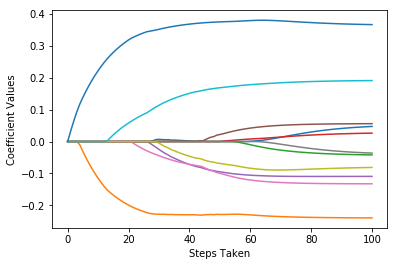

In [3]:
__author__ = 'mike-bowles'

import urllib.request, urllib.error, urllib.parse
import numpy
from sklearn import datasets, linear_model
from math import sqrt
import matplotlib.pyplot as plot
def S(z, gamma):
    if gamma >= abs(z):
        return 0.0
    return (z/abs(z))*(abs(z) - gamma)

#read data into iterable
target_url = ("http://archive.ics.uci.edu/ml/machine-learning-"
"databases/wine-quality/winequality-red.csv")
data = urllib.request.urlopen(target_url)

xList = []
labels = []
names = []
firstLine = True
for line in data:
    if firstLine:
        names = line.decode().strip().split(";")
        firstLine = False
    else:
        #split on semi-colon
        row = line.decode().strip().split(";")
        #put labels in separate array
        labels.append(float(row[-1]))
        #remove label from row
        row.pop()
        #convert row to floats
        floatRow = [float(num) for num in row]
        xList.append(floatRow)

#Normalize columns in x and labels

nrows = len(xList)
ncols = len(xList[0])

#calculate means and variances
xMeans = []
xSD = []
for i in range(ncols):
    col = [xList[j][i] for j in range(nrows)]
    mean = sum(col)/nrows
    xMeans.append(mean)
    colDiff = [(xList[j][i] - mean) for j in range(nrows)]
    sumSq = sum([colDiff[i] * colDiff[i] for i in range(nrows)])
    stdDev = sqrt(sumSq/nrows)
    xSD.append(stdDev)

#use calculate mean and standard deviation to normalize xList
xNormalized = []
for i in range(nrows):
    rowNormalized = [(xList[i][j] - xMeans[j])/xSD[j]
                     for j in range(ncols)]
    xNormalized.append(rowNormalized)

#Normalize labels
meanLabel = sum(labels)/nrows
sdLabel = sqrt(sum([(labels[i] - meanLabel) * (labels[i] -
                meanLabel) for i in range(nrows)])/nrows)

labelNormalized = [(labels[i] - meanLabel)/sdLabel for i in range(nrows)]

#select value for alpha parameter

alpha = 1.0

#make a pass through the data to determine value of lambda that
# just suppresses all coefficients.
#start with betas all equal to zero.


xy = [0.0]*ncols
for i in range(nrows):
    for j in range(ncols):
        xy[j] += xNormalized[i][j] * labelNormalized[i]

maxXY = 0.0
for i in range(ncols):
    val = abs(xy[i])/nrows
    if val > maxXY:
        maxXY = val

#calculate starting value for lambda
lam = maxXY/alpha

#this value of lambda corresponds to beta = list of 0's
#initialize a vector of coefficients beta
beta = [0.0] * ncols

#initialize matrix of betas at each step
betaMat = []
betaMat.append(list(beta))

#begin iteration
nSteps = 100
lamMult = 0.93 #100 steps gives reduction by factor of 1000 in
               # lambda (recommended by authors)
nzList = []

for iStep in range(nSteps):
    #make lambda smaller so that some coefficient becomes non-zero
    lam = lam * lamMult

    deltaBeta = 100.0
    eps = 0.01
    iterStep = 0
    betaInner = list(beta)
    while deltaBeta > eps:
        iterStep += 1
        if iterStep > 100: break

        #cycle through attributes and update one-at-a-time
        #record starting value for comparison
        betaStart = list(betaInner)
        for iCol in range(ncols):

            xyj = 0.0
            for i in range(nrows):
                #calculate residual with current value of beta
                labelHat = sum([xNormalized[i][k]*betaInner[k]
                                for k in range(ncols)])
                residual = labelNormalized[i] - labelHat

                xyj += xNormalized[i][iCol] * residual

            uncBeta = xyj/nrows + betaInner[iCol]
            betaInner[iCol] = S(uncBeta, lam * alpha) / (1 +
                                            lam * (1 - alpha))

        sumDiff = sum([abs(betaInner[n] - betaStart[n])
                       for n in range(ncols)])
        sumBeta = sum([abs(betaInner[n]) for n in range(ncols)])
        deltaBeta = sumDiff/sumBeta
    print(iStep, iterStep)
    beta = betaInner

    #add newly determined beta to list
    betaMat.append(beta)

    #keep track of the order in which the betas become non-zero
    nzBeta = [index for index in range(ncols) if beta[index] != 0.0]
    for q in nzBeta:
        if (q in nzList) == False:
            nzList.append(q)

#print out the ordered list of betas
nameList = [names[nzList[i]] for i in range(len(nzList))]
print(nameList)

nPts = len(betaMat)
for i in range(ncols):
    #plot range of beta values for each attribute
    coefCurve = [betaMat[k][i] for k in range(nPts)]
    xaxis = range(nPts)
    plot.plot(xaxis, coefCurve)

plot.xlabel("Steps Taken")
plot.ylabel(("Coefficient Values"))
plot.show()

### larsAbalone.py

['Shell weight', 'Height', 'Sex2', 'Shucked weight', 'Diameter', 'Sex1']


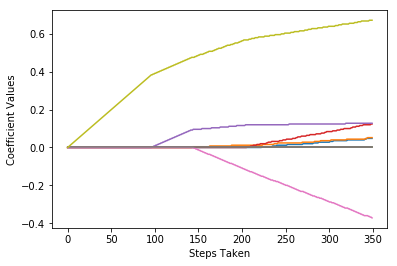

In [4]:
__author__ = 'mike_bowles'

import urllib.request, urllib.error, urllib.parse
from pylab import *
import matplotlib.pyplot as plot

target_url = "http://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data"
#read abalone data
data = urllib.request.urlopen(target_url)

xList = []
labels = []

for line in data:
    #split on semi-colon
    row = line.decode().strip().split(",")

    #put labels in separate array and remove label from row
    labels.append(float(row.pop()))

    #form list of list of attributes (all strings)
    xList.append(row)

names = ['Sex', 'Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight', 'Viscera weight', 'Shell weight', 'Rings']

#code three-valued sex attribute as numeric
xCoded = []
for row in xList:
    #first code the three-valued sex variable
    codedSex = [0.0, 0.0]
    if row[0] == 'M': codedSex[0] = 1.0
    if row[0] == 'F': codedSex[1] = 1.0

    numRow = [float(row[i]) for i in range(1,len(row))]
    rowCoded = list(codedSex) + numRow
    xCoded.append(rowCoded)

namesCoded = ['Sex1', 'Sex2', 'Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight', 'Viscera weight', 'Shell weight', 'Rings']

nrows = len(xCoded)
ncols = len(xCoded[1])

xMeans = []
xSD = []
for i in range(ncols):
    col = [xCoded[j][i] for j in range(nrows)]
    mean = sum(col)/nrows
    xMeans.append(mean)
    colDiff = [(xCoded[j][i] - mean) for j in range(nrows)]
    sumSq = sum([colDiff[i] * colDiff[i] for i in range(nrows)])
    stdDev = sqrt(sumSq/nrows)
    xSD.append(stdDev)

#use calculate mean and standard deviation to normalize xCoded
xNormalized = []
for i in range(nrows):
    rowNormalized = [(xCoded[i][j] - xMeans[j])/xSD[j] for j in range(ncols)]
    xNormalized.append(rowNormalized)

#Normalize labels
meanLabel = sum(labels)/nrows
sdLabel = sqrt(sum([(labels[i] - meanLabel) * (labels[i] - meanLabel) for i in range(nrows)])/nrows)

labelNormalized = [(labels[i] - meanLabel)/sdLabel for i in range(nrows)]

#initialize a vector of coefficients beta
beta = [0.0] * ncols

#initialize matrix of betas at each step
betaMat = []
betaMat.append(list(beta))


#number of steps to take
nSteps = 350
stepSize = 0.004
nzList = []

for i in range(nSteps):
    #calculate residuals
    residuals = [0.0] * nrows
    for j in range(nrows):
        labelsHat = sum([xNormalized[j][k] * beta[k] for k in range(ncols)])
        residuals[j] = labelNormalized[j] - labelsHat

    #calculate correlation between attribute columns from normalized wine and residual
    corr = [0.0] * ncols

    for j in range(ncols):
        corr[j] = sum([xNormalized[k][j] * residuals[k] for k in range(nrows)]) / nrows

    iStar = 0
    corrStar = corr[0]

    for j in range(1, (ncols)):
        if abs(corrStar) < abs(corr[j]):
            iStar = j; corrStar = corr[j]

    beta[iStar] += stepSize * corrStar / abs(corrStar)
    betaMat.append(list(beta))


    nzBeta = [index for index in range(ncols) if beta[index] != 0.0]
    for q in nzBeta:
        if (q in nzList) == False:
            nzList.append(q)

nameList = [namesCoded[nzList[i]] for i in range(len(nzList))]

print(nameList)
for i in range(ncols):
    #plot range of beta values for each attribute
    coefCurve = [betaMat[k][i] for k in range(nSteps)]
    xaxis = range(nSteps)
    plot.plot(xaxis, coefCurve)

plot.xlabel("Steps Taken")
plot.ylabel(("Coefficient Values"))
plot.show()

### larsRocksVMines.py

['V10', 'V48', 'V44', 'V11', 'V35', 'V51', 'V20', 'V3', 'V21', 'V15', 'V43', 'V0', 'V22', 'V45', 'V53', 'V27', 'V30', 'V50', 'V58', 'V46', 'V56', 'V28', 'V39']


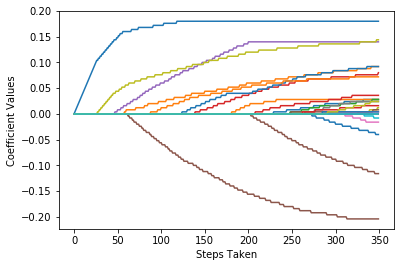

In [5]:
__author__ = 'mike_bowles'
import urllib.request, urllib.error, urllib.parse
import sys
from math import sqrt
import matplotlib.pyplot as plot

#read data from uci data repository
target_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/undocumented/connectionist-bench/sonar/sonar.all-data"
data = urllib.request.urlopen(target_url)


#arrange data into list for labels and list of lists for attributes
xList = []


for line in data:
    #split on comma
    row = line.decode().strip().split(",")
    xList.append(row)

#separate labels from attributes, convert from attributes from string to numeric and convert "M" to 1 and "R" to 0

xNum = []
labels = []

for row in xList:
    lastCol = row.pop()
    if lastCol == "M":
        labels.append(1.0)
    else:
        labels.append(0.0)
    attrRow = [float(elt) for elt in row]
    xNum.append(attrRow)

#number of rows and columns in x matrix
nrow = len(xNum)
ncol = len(xNum[1])



#calculate means and variances
xMeans = []
xSD = []
for i in range(ncol):
    col = [xNum[j][i] for j in range(nrow)]
    mean = sum(col)/nrow
    xMeans.append(mean)
    colDiff = [(xNum[j][i] - mean) for j in range(nrow)]
    sumSq = sum([colDiff[i] * colDiff[i] for i in range(nrow)])
    stdDev = sqrt(sumSq/nrow)
    xSD.append(stdDev)

#use calculate mean and standard deviation to normalize xNum
xNormalized = []
for i in range(nrow):
    rowNormalized = [(xNum[i][j] - xMeans[j])/xSD[j] for j in range(ncol)]
    xNormalized.append(rowNormalized)

#Normalize labels
meanLabel = sum(labels)/nrow
sdLabel = sqrt(sum([(labels[i] - meanLabel) * (labels[i] - meanLabel) for i in range(nrow)])/nrow)

labelNormalized = [(labels[i] - meanLabel)/sdLabel for i in range(nrow)]

#initialize a vector of coefficients beta
beta = [0.0] * ncol

#initialize matrix of betas at each step
betaMat = []
betaMat.append(list(beta))


#number of steps to take
nSteps = 350
stepSize = 0.004
nzList = []

for i in range(nSteps):
    #calculate residuals
    residuals = [0.0] * nrow
    for j in range(nrow):
        labelsHat = sum([xNormalized[j][k] * beta[k] for k in range(ncol)])
        residuals[j] = labelNormalized[j] - labelsHat

    #calculate correlation between attribute columns from normalized wine and residual
    corr = [0.0] * ncol

    for j in range(ncol):
        corr[j] = sum([xNormalized[k][j] * residuals[k] for k in range(nrow)]) / nrow

    iStar = 0
    corrStar = corr[0]

    for j in range(1, (ncol)):
        if abs(corrStar) < abs(corr[j]):
            iStar = j; corrStar = corr[j]

    beta[iStar] += stepSize * corrStar / abs(corrStar)
    betaMat.append(list(beta))


    nzBeta = [index for index in range(ncol) if beta[index] != 0.0]
    for q in nzBeta:
        if (q in nzList) == False:
            nzList.append(q)

#make up names for columns of xNum
names = ['V' + str(i) for i in range(ncol)]
nameList = [names[nzList[i]] for i in range(len(nzList))]

print(nameList)
for i in range(ncol):
    #plot range of beta values for each attribute
    coefCurve = [betaMat[k][i] for k in range(nSteps)]
    xaxis = range(nSteps)
    plot.plot(xaxis, coefCurve)

plot.xlabel("Steps Taken")
plot.ylabel(("Coefficient Values"))
plot.show()

### larsWine2.py

['"alcohol"', '"volatile acidity"', '"sulphates"', '"total sulfur dioxide"', '"chlorides"', '"fixed acidity"', '"pH"', '"free sulfur dioxide"', '"citric acid"', '"residual sugar"', '"density"']


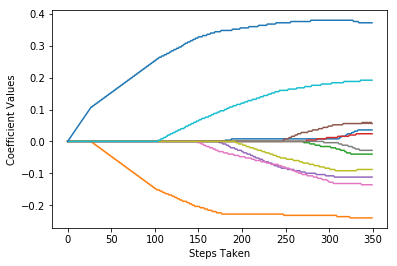

In [7]:
__author__ = 'mike-bowles'

import urllib.request, urllib.error, urllib.parse
import numpy
from sklearn import datasets, linear_model
from math import sqrt
import matplotlib.pyplot as plot

#read data into iterable
target_url = "http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = urllib.request.urlopen(target_url)

xList = []
labels = []
names = []
firstLine = True
for line in data:
    if firstLine:
        names = line.decode().strip().split(";")
        firstLine = False
    else:
        #split on semi-colon
        row = line.decode().strip().split(";")
        #put labels in separate array
        labels.append(float(row[-1]))
        #remove label from row
        row.pop()
        #convert row to floats
        floatRow = [float(num) for num in row]
        xList.append(floatRow)

#Normalize columns in x and labels

nrows = len(xList)
ncols = len(xList[0])

#calculate means and variances
xMeans = []
xSD = []
for i in range(ncols):
    col = [xList[j][i] for j in range(nrows)]
    mean = sum(col)/nrows
    xMeans.append(mean)
    colDiff = [(xList[j][i] - mean) for j in range(nrows)]
    sumSq = sum([colDiff[i] * colDiff[i] for i in range(nrows)])
    stdDev = sqrt(sumSq/nrows)
    xSD.append(stdDev)

#use calculate mean and standard deviation to normalize xList
xNormalized = []
for i in range(nrows):
    rowNormalized = [(xList[i][j] - xMeans[j])/xSD[j] for j in range(ncols)]
    xNormalized.append(rowNormalized)

#Normalize labels
meanLabel = sum(labels)/nrows
sdLabel = sqrt(sum([(labels[i] - meanLabel) * (labels[i] - meanLabel) for i in range(nrows)])/nrows)

labelNormalized = [(labels[i] - meanLabel)/sdLabel for i in range(nrows)]

#initialize a vector of coefficients beta
beta = [0.0] * ncols

#initialize matrix of betas at each step
betaMat = []
betaMat.append(list(beta))


#number of steps to take
nSteps = 350
stepSize = 0.004
nzList = []

for i in range(nSteps):
    #calculate residuals
    residuals = [0.0] * nrows
    for j in range(nrows):
        labelsHat = sum([xNormalized[j][k] * beta[k] for k in range(ncols)])
        residuals[j] = labelNormalized[j] - labelsHat

    #calculate correlation between attribute columns from normalized wine and residual
    corr = [0.0] * ncols

    for j in range(ncols):
        corr[j] = sum([xNormalized[k][j] * residuals[k] for k in range(nrows)]) / nrows

    iStar = 0
    corrStar = corr[0]

    for j in range(1, (ncols)):
        if abs(corrStar) < abs(corr[j]):
            iStar = j; corrStar = corr[j]

    beta[iStar] += stepSize * corrStar / abs(corrStar)
    betaMat.append(list(beta))


    nzBeta = [index for index in range(ncols) if beta[index] != 0.0]
    for q in nzBeta:
        if (q in nzList) == False:
            nzList.append(q)

nameList = [names[nzList[i]] for i in range(len(nzList))]

print(nameList)
for i in range(ncols):
    #plot range of beta values for each attribute
    coefCurve = [betaMat[k][i] for k in range(nSteps)]
    xaxis = range(nSteps)
    plot.plot(xaxis, coefCurve)

plot.xlabel("Steps Taken")
plot.ylabel(("Coefficient Values"))
plot.show()

### larsWineCV.py

Minimum Mean Square Error 0.587301893314
Index of Minimum Mean Square Error 311


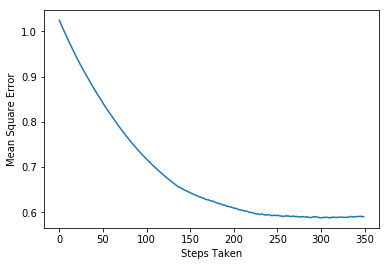

In [8]:
__author__ = 'mike-bowles'

import urllib.request, urllib.error, urllib.parse
import numpy
from sklearn import datasets, linear_model
from math import sqrt
import matplotlib.pyplot as plot


#read data into iterable
target_url = "http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = urllib.request.urlopen(target_url)

xList = []
labels = []
names = []
firstLine = True
for line in data:
    if firstLine:
        names = line.decode().strip().split(";")
        firstLine = False
    else:
        #split on semi-colon
        row = line.decode().strip().split(";")
        #put labels in separate array
        labels.append(float(row[-1]))
        #remove label from row
        row.pop()
        #convert row to floats
        floatRow = [float(num) for num in row]
        xList.append(floatRow)

#Normalize columns in x and labels

nrows = len(xList)
ncols = len(xList[0])

#calculate means and variances
xMeans = []
xSD = []
for i in range(ncols):
    col = [xList[j][i] for j in range(nrows)]
    mean = sum(col)/nrows
    xMeans.append(mean)
    colDiff = [(xList[j][i] - mean) for j in range(nrows)]
    sumSq = sum([colDiff[i] * colDiff[i] for i in range(nrows)])
    stdDev = sqrt(sumSq/nrows)
    xSD.append(stdDev)

#use calculated mean and standard deviation to normalize xList
xNormalized = []
for i in range(nrows):
    rowNormalized = [(xList[i][j] - xMeans[j])/xSD[j] for j in range(ncols)]
    xNormalized.append(rowNormalized)

#Normalize labels
meanLabel = sum(labels)/nrows
sdLabel = sqrt(sum([(labels[i] - meanLabel) * (labels[i] - meanLabel) for i in range(nrows)])/nrows)

labelNormalized = [(labels[i] - meanLabel)/sdLabel for i in range(nrows)]

#Build cross-validation loop to determine best coefficient values.

#number of cross validation folds
nxval = 10

#number of steps and step size
nSteps = 350
stepSize = 0.004

#initialize list for storing errors.
errors = []
for i in range(nSteps):
    b = []
    errors.append(b)


for ixval in range(nxval):
    #Define test and training index sets
    idxTest = [a for a in range(nrows) if a%nxval == ixval*nxval]
    idxTrain = [a for a in range(nrows) if a%nxval != ixval*nxval]

    #Define test and training attribute and label sets
    xTrain = [xNormalized[r] for r in idxTrain]
    xTest = [xNormalized[r] for r in idxTest]
    labelTrain = [labelNormalized[r] for r in idxTrain]
    labelTest = [labelNormalized[r] for r in idxTest]

    #Train LARS regression on Training Data
    nrowsTrain = len(idxTrain)
    nrowsTest = len(idxTest)

    #initialize a vector of coefficients beta
    beta = [0.0] * ncols

    #initialize matrix of betas at each step
    betaMat = []
    betaMat.append(list(beta))

    for iStep in range(nSteps):
        #calculate residuals
        residuals = [0.0] * nrows
        for j in range(nrowsTrain):
            labelsHat = sum([xTrain[j][k] * beta[k] for k in range(ncols)])
            residuals[j] = labelTrain[j] - labelsHat

        #calculate correlation between attribute columns from normalized wine and residual
        corr = [0.0] * ncols

        for j in range(ncols):
            corr[j] = sum([xTrain[k][j] * residuals[k] for k in range(nrowsTrain)]) / nrowsTrain

        iStar = 0
        corrStar = corr[0]

        for j in range(1, (ncols)):
            if abs(corrStar) < abs(corr[j]):
                iStar = j; corrStar = corr[j]

        beta[iStar] += stepSize * corrStar / abs(corrStar)
        betaMat.append(list(beta))

        #Use beta just calculated to predict and accumulate out of sample error - not being used in the calc of beta
        for j in range(nrowsTest):
            labelsHat = sum([xTest[j][k] * beta[k] for k in range(ncols)])
            err = labelTest[j] - labelsHat
            errors[iStep].append(err)

cvCurve = []
for errVect in errors:
    mse = sum([x*x for x in errVect])/len(errVect)
    cvCurve.append(mse)

minMse = min(cvCurve)
minPt = [i for i in range(len(cvCurve)) if cvCurve[i] == minMse ][0]
print("Minimum Mean Square Error", minMse)
print("Index of Minimum Mean Square Error", minPt)

xaxis = range(len(cvCurve))
plot.plot(xaxis, cvCurve)

plot.xlabel("Steps Taken")
plot.ylabel(("Mean Square Error"))
plot.show()

### wineBasisExpand.py

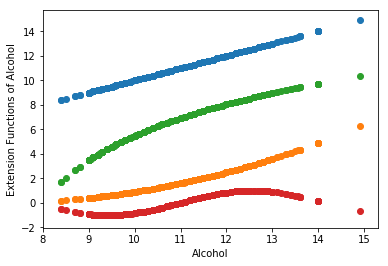

In [9]:
__author__ = 'mike-bowles'

import urllib.request, urllib.error, urllib.parse
import matplotlib.pyplot as plot
from math import sqrt, cos, log

#read data into iterable
target_url = "http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = urllib.request.urlopen(target_url)

xList = []
labels = []
names = []
firstLine = True
for line in data:
    if firstLine:
        names = line.decode().strip().split(";")
        firstLine = False
    else:
        #split on semi-colon
        row = line.decode().strip().split(";")
        #put labels in separate array
        labels.append(float(row[-1]))
        #remove label from row
        row.pop()
        #convert row to floats
        floatRow = [float(num) for num in row]
        xList.append(floatRow)


#extend the alcohol variable (the last column in that attribute matrix
xExtended = []
alchCol = len(xList[1])


for row in xList:
    newRow = list(row)
    alch = row[alchCol - 1]
    newRow.append((alch - 7) * (alch - 7)/10)
    newRow.append(5 * log(alch - 7))
    newRow.append(cos(alch))
    xExtended.append(newRow)

nrow = len(xList)
v1 = [xExtended[j][alchCol - 1] for j in range(nrow)]

for i in range(4):
    v2 = [xExtended[j][alchCol - 1 + i] for j in range(nrow)]
    plot.scatter(v1,v2)

plot.xlabel("Alcohol")
plot.ylabel(("Extension Functions of Alcohol"))
plot.show()